Este notebook, sobre teledetección, se centra en el análisis espacial para exploración simulando el distrito Domeyko.

Autor: Pablo Toledo

El objetivo principal es simular y procesar datos de teledetección para identificar anomalías geológicas sutiles:

Simulación de Datos Satelitales: Genera bandas espectrales sintéticas que imitan el comportamiento físico de las rocas en el infrarrojo de onda corta (SWIR), permitiendo mapear la alteración mineral (arcillas) típica de los sistemas de pórfido.

Detección de Bordes con Visión Artificial: Aplica filtros matemáticos (Sobel) a los datos de magnetometría para identificar lineamientos y estructuras geológicas, basicamente marca cambios magneticos que podrian ser indicio de estructuras.

Segmentación Automática: Utiliza un algoritmo de aprendizaje no supervisado (K-Means) para clasificar los píxeles de la imagen en unidades litológicas distintas, basándose en sus firmas magnéticas y espectrales.

Visualización Integrada: Combina todas estas capas de información en un mapa compuesto RGB y un dashboard de análisis, facilitando la identificación de blancos de exploración.

---

Se utilizaron datos del notebook Exploracion_1.ipynb

Se utilizaron asistentes de IA para acelerar la escritura de código Python, permitiendo enfocar el esfuerzo en el análisis de datos, la interpretación geológica y la validación.

Cargando datos del sistema DeepSight...
Datos cargados: 5000 puntos. Listos para simulación espectral.
--- INICIANDO PROCESAMIENTO DE IMÁGENES SATELITALES (DEEPSIGHT v4.0) ---
[1/4] Simulando sensores SWIR (Short-Wave Infrared)...
[2/4] Calculando índices de alteración y detección de bordes...
[3/4] Ejecutando K-Means Clustering sobre píxeles para autodefinir litologías...
[4/4] Generando Dashboard de Teledetección...


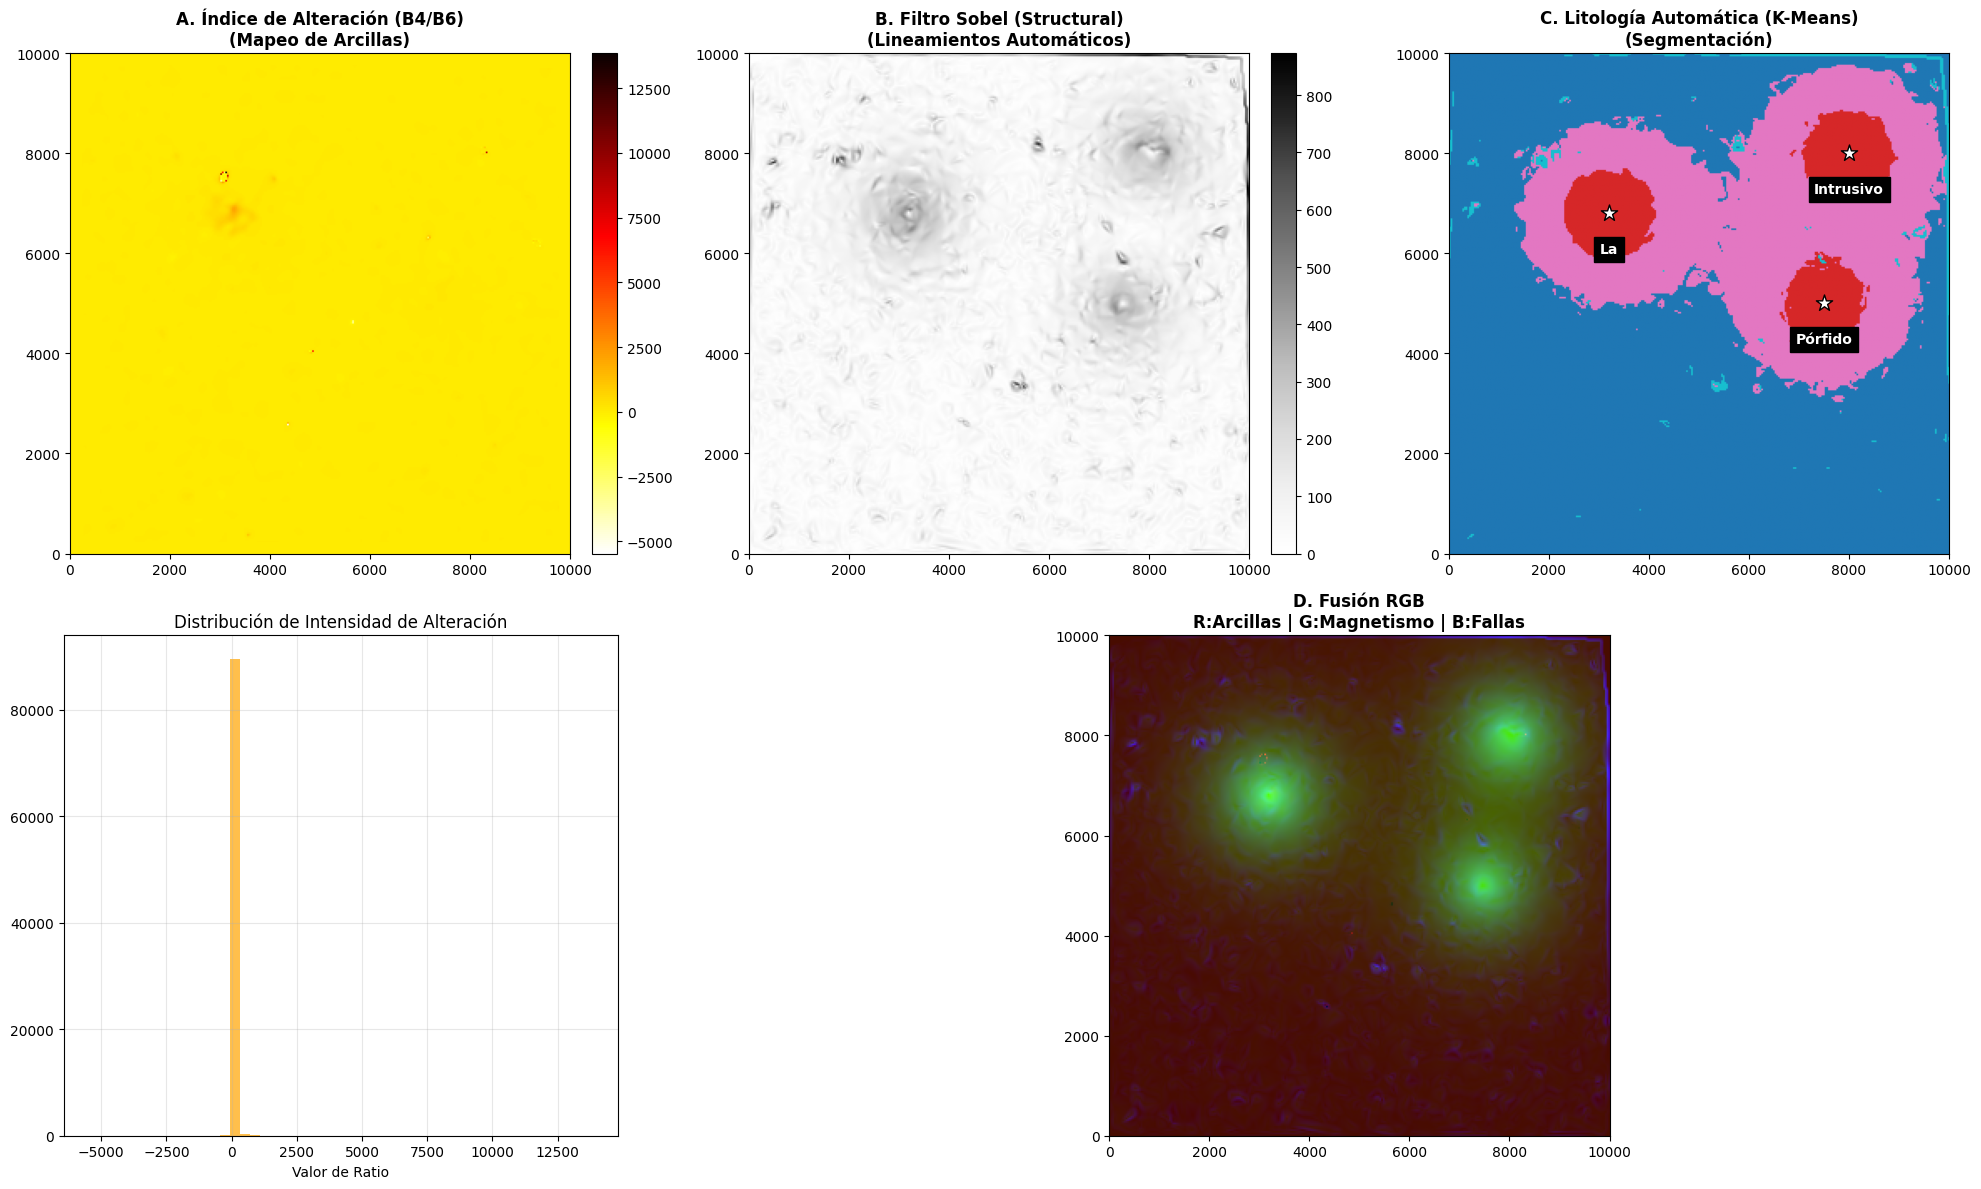

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter, sobel
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Cargar los datos
print("Cargando datos del sistema DeepSight...")
df = pd.read_csv('/content/domeyko_simulated_data.csv')
targets_df = pd.read_csv('/content/domeyko_targets.csv')
targets = targets_df.to_dict('records') # Convertir de vuelta a lista de dicts

print(f"Datos cargados: {len(df)} puntos. Listos para simulación espectral.")

def generar_analisis_satelital_avanzado(df, targets):
    print("--- INICIANDO PROCESAMIENTO DE IMÁGENES SATELITALES (DEEPSIGHT v4.0) ---")

    # GENERACIÓN DE GRID RASTER (Resolución HD)
    resolution = 300j # Aumentamos resolución a 300x300
    grid_x, grid_y = np.mgrid[0:10000:resolution, 0:10000:resolution]

    # SIMULACIÓN DE BANDAS ESPECTRALES (Física de Rocas)
    print("[1/4] Simulando sensores SWIR (Short-Wave Infrared)...")

    # Banda 4 (1.65µm): Reflectancia general (Fondo)
    b4_raw = griddata((df['Este'], df['Norte']), df['Cu_ppm'], (grid_x, grid_y), method='cubic')
    # Agregamos "ruido de sensor" para realismo
    noise = np.random.normal(0, 5, b4_raw.shape)
    b4_band = gaussian_filter(b4_raw + noise, sigma=1.5)
    b4_band = np.nan_to_num(b4_band) # FIX: Replace NaNs with 0

    # Banda 6 (2.20µm): Absorción de Arcillas (OH)
    # Invertimos: Zonas de alteración (Phyllic) absorben luz -> Valores bajos
    phyllic_raw = griddata((df['Este'], df['Norte']), df['ASTER_Phyllic'], (grid_x, grid_y), method='cubic')
    b6_band = 1.0 - (phyllic_raw * 0.9)
    b6_band = gaussian_filter(b6_band + (noise*0.01), sigma=1.5)
    b6_band = np.nan_to_num(b6_band) # FIX: Replace NaNs with 0

    # ÍNDICES ESPECTRALES & VISIÓN ARTIFICIAL
    print("[2/4] Calculando índices de alteración y detección de bordes...")

    # Ratio de Alteración (Band Ratioing: B4/B6)
    # Técnica estándar para resaltar caolinita/alunita
    alteration_ratio = b4_band / (b6_band + 0.01)
    alteration_ratio = np.nan_to_num(alteration_ratio) # FIX: Replace NaNs with 0

    # Filtro Sobel (Edge Detection) sobre Magnetometría
    mag_grid = griddata((df['Este'], df['Norte']), df['Mag_RTP'], (grid_x, grid_y), method='cubic')
    mag_grid = np.nan_to_num(mag_grid)
    sx = sobel(mag_grid, axis=0)
    sy = sobel(mag_grid, axis=1)
    sob_mag = np.hypot(sx, sy) # Magnitud del gradiente estructural

    # SEGMENTACIÓN AUTOMÁTICA (ML NO SUPERVISADO)
    print("[3/4] Ejecutando K-Means Clustering sobre píxeles para autodefinir litologías...")

    # Preparamos los datos: Cada píxel es una muestra con 3 características (Alt, Mag, Estructura)
    # Aplanamos las imágenes (flatten) para que entren al modelo
    X_img = np.column_stack((
        MinMaxScaler().fit_transform(alteration_ratio.flatten().reshape(-1, 1)),
        MinMaxScaler().fit_transform(mag_grid.flatten().reshape(-1, 1)),
        MinMaxScaler().fit_transform(sob_mag.flatten().reshape(-1, 1))
    ))

    # K-Means con 4 clusters (ej: Fondo, Alteración, Intrusivo, Estructura)
    kmeans_img = KMeans(n_clusters=4, random_state=42, n_init=10)
    segments = kmeans_img.fit_predict(X_img)
    segments_grid = segments.reshape(alteration_ratio.shape) # Volvemos a forma de imagen

    # VISUALIZACIÓN
    print("[4/4] Generando Dashboard de Teledetección...")
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 3) # Grid 2 filas x 3 columnas

    # Mapa A: Alteración (Ratio)
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(alteration_ratio.T, extent=(0,10000,0,10000), origin='lower', cmap='hot_r')
    ax1.set_title('A. Índice de Alteración (B4/B6)\n(Mapeo de Arcillas)', fontweight='bold')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    # Histograma A (QC de Alteración)
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.hist(alteration_ratio.flatten(), bins=50, color='orange', alpha=0.7)
    ax2.set_title('Distribución de Intensidad de Alteración')
    ax2.set_xlabel('Valor de Ratio')
    ax2.grid(True, alpha=0.3)

    # Mapa B: Visión Artificial (Estructura)
    ax3 = fig.add_subplot(gs[0, 1])
    im3 = ax3.imshow(sob_mag.T, extent=(0,10000,0,10000), origin='lower', cmap='Greys')
    ax3.set_title('B. Filtro Sobel (Structural)\n(Lineamientos Automáticos)', fontweight='bold')
    plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

    # Mapa C: Clasificación K-Means (Segmentación)
    ax4 = fig.add_subplot(gs[0, 2])
    im4 = ax4.imshow(segments_grid.T, extent=(0,10000,0,10000), origin='lower', cmap='tab10')
    ax4.set_title('C. Litología Automática (K-Means)\n(Segmentación)', fontweight='bold')

    # Superponer Targets en el mapa final
    for t in targets:
        ax4.scatter(t['x'], t['y'], s=150, c='white', marker='*', edgecolors='black')
        ax4.text(t['x'], t['y']-800, t['type'].split()[0], color='white', fontweight='bold', ha='center', backgroundcolor='black')

    # Fusión RGB (Solo visualización estética)
    ax5 = fig.add_subplot(gs[1, 1:])
    def norm(arr): return (arr - np.nanmin(arr)) / (np.nanmax(arr) - np.nanmin(arr))
    rgb_img = np.dstack((norm(alteration_ratio.T), norm(mag_grid.T), norm(sob_mag.T)))
    ax5.imshow(rgb_img, extent=(0,10000,0,10000), origin='lower')
    ax5.set_title('D. Fusión RGB\nR:Arcillas | G:Magnetismo | B:Fallas', fontweight='bold')

    plt.tight_layout()
    plt.show()

# EJECUTAR el análisis satelital con los datos cargados
generar_analisis_satelital_avanzado(df, targets)